### SHRED applied to Øresund

This iPython notebook gives an introductory walkthrough to using SHRED models.  

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mikeio


num_sensors = 3 
lags = 52

sensor_locations = np.array([2849,   41, 2452])
np.save("Data/sensor_locations.npy",sensor_locations)


In [2]:
data_times = slice("2022-01-01", "2022-04-30")

# Load and save boundary data
ds = mikeio.read("Data/oresund/BC_SFC_North_2D_2014-2024.dfs1",time=data_times, items=[0])
# ds.to_dfs("Data/oresund/BCn.dfs1")
ds.to_dfs("Data/oresund/BCn_1y.dfs1")
print(f"There are {ds.geometry.x.shape[0]} points in the North boundary")

ds = mikeio.read("Data/oresund/BC_SFC_South_2D_2014-2024.dfs1",time=data_times, items=[0])
# ds.to_dfs("Data/oresund/BCs.dfs1")
ds.to_dfs("Data/oresund/BCs_1y.dfs1")
print(f"There are {ds.geometry.x.shape[0]} points in the South boundary")


There are 13 points in the North boundary
There are 29 points in the South boundary


In [3]:
ds = mikeio.read("Data/Area.dfsu",time=data_times, items=[0])
# ds.to_dfs("Data/Area_5m.dfsu")
ds.to_dfs("Data/Area_1y.dfsu")
load_X = ds[0].to_numpy()
load_X.shape
n = load_X.shape[0]
m = load_X.shape[1]

In [4]:
south_node_coords = ds.geometry.node_coordinates[ds.geometry.codes==3,:2]
north_node_coords = ds.geometry.node_coordinates[ds.geometry.codes==2,:2]
np.save("Data/oresund/south_node_coords.npy", south_node_coords)
np.save("Data/oresund/north_node_coords.npy", north_node_coords)

We now select indices to divide the data into training, validation, and test sets.

In [5]:
# FRTP:
n_test = 174
n_valid = 174
n_train = 1000

train_indices = np.arange(0, n_train)
valid_test_indices = np.arange(n_train,n_train+n_valid)
test_indices = np.arange(n_train+n_valid,n_train+n_valid+n_test)


In [6]:
np.load("ForecastingResults/sensor_locations.npy")

array([2849,   41, 2452])

In [7]:
reconstruction = np.load('ReconstructingResults/reconstructions.npy')
truths = np.load('ReconstructingResults/truth.npy')
sensor_locations = np.load('ForecastingResults/sensor_locations.npy')

In [8]:
# Default from paper ?!?!?!
# Test Reconstruction Error: 
# 0.0193155

# When train and test are clearly separated:
# Test Reconstruction Error: 
# 0.04866559

In [9]:
def plot_reconstruction(reconstruction,truths,plot_index, sensor_coords, num_sensors=10, title="SHRED reconstruction"):
    
    # Create dataarrays for plotting
    da_plot_recon = ds[0].sel(time=ds.time[test_indices[plot_index]+ lags - 1]).copy()
    da_plot_true = da_plot_recon.copy()
    da_plot_err = da_plot_recon.copy()
    # Fill with values from the reconstruction and the ground truth, as well as errors
    da_plot_recon.values = reconstruction[plot_index]
    da_plot_true.values = truths[plot_index]
    da_plot_err.values =  truths[plot_index]-reconstruction[plot_index]
    # min and max values for the colorbar
    vmin = -max(abs(np.min(da_plot_err.values)),abs(np.max(da_plot_err.values)))
    vmax = max(abs(np.min(da_plot_err.values)),abs(np.max(da_plot_err.values)))

    fig,axs = plt.subplots(1,3,figsize=(15,6))
    fig.suptitle('SHRED reconstruction of sensor data')

    da_plot_true.plot(ax = axs[1],add_colorbar=False)
    cbar = fig.colorbar(axs[1].collections[0], ax=axs[1],label='Surface elevation [m]')
    axs[1].set_title('Ground truth')

    da_plot_err.plot(ax = axs[2],cmap="bwr",vmin=vmin,vmax=vmax,add_colorbar=False)
    cbar = fig.colorbar(axs[2].collections[0], ax=axs[2],label='Error')
    axs[2].set_title('Error')

    da_plot_recon.plot(ax = axs[0],add_colorbar=False)
    cbar = fig.colorbar(axs[0].collections[0], ax=axs[0],label='Surface elevation [m]')
    axs[0].set_title(f'Reconstruction: {da_plot_recon.time[0].strftime("%d-%m-%Y %H:%M:%S")}')

    # Add a red dot to the spatial points indicated by the sensor locations
    for i in range(num_sensors):
        axs[0].scatter(sensor_coords[i,0], sensor_coords[i,1], color='red', s=40, label='Sensor location')
        axs[1].scatter(sensor_coords[i,0], sensor_coords[i,1], color='red', s=40, label='Sensor location')

    plt.tight_layout()

    rmspe = np.sqrt(np.mean(np.square((da_plot_err.values / da_plot_true.values)), axis=0))
    rmse = np.sqrt(np.mean(np.square((da_plot_err.values)), axis=0))

    return rmspe, rmse

def compute_RMSES(reconstruction,truths):
    rmspe = np.sqrt(np.mean(np.square((truths-reconstruction)/truths)))
    rmse = np.sqrt(np.mean(np.square(truths-reconstruction)))
    print('RMSE: ', rmse)
    print('RMSPE:', rmspe)

RMSE:  0.026333563
RMSPE: 25.45918


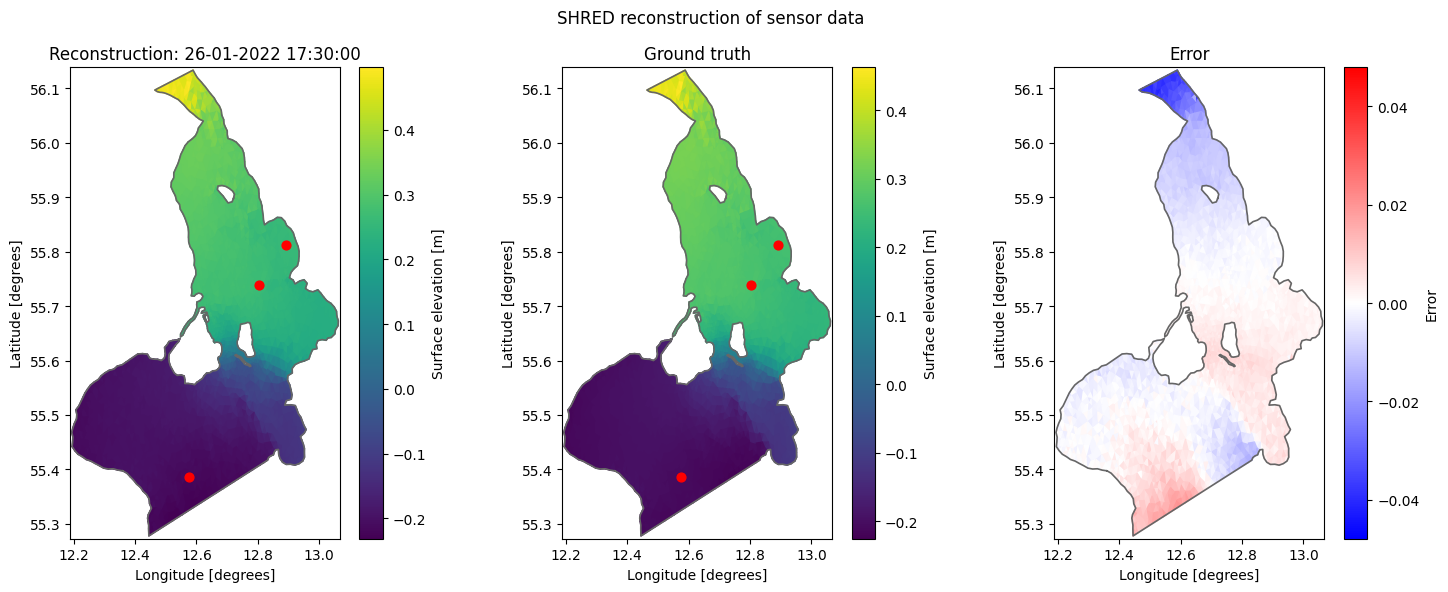

In [10]:
elem_cor = ds[0].geometry.element_coordinates
sensor_coords = elem_cor[sensor_locations]

plot_index = 10

rmspe, rmse = plot_reconstruction(reconstruction,truths,plot_index, sensor_coords, num_sensors=3)
compute_RMSES(reconstruction,truths)

## Reconstruction from forcing data

In [11]:
val_length = 20
num_sensors = 6
train_indices = np.arange(0, int(n*0.85))
valid_indices = np.arange(int(n*0.85), int(n*0.85) + val_length)
test_indices = np.arange(int(n*0.85) + val_length, n - lags)

In [12]:
sensor_locations = np.load("ReconstructingResults/oresund_forcing/sensor_locations_forcing_sensor6lag52.npy")
sensor_locations

array([ 3,  6, 10, 20, 26, 33])

In [13]:
reconstruction = np.load('ReconstructingResults/oresund_forcing/reconstructions_forcing_sensor6lag52.npy')
truths = np.load('ReconstructingResults/oresund_forcing/truth.npy')

RMSE:  0.012223365
RMSPE: 303.22916


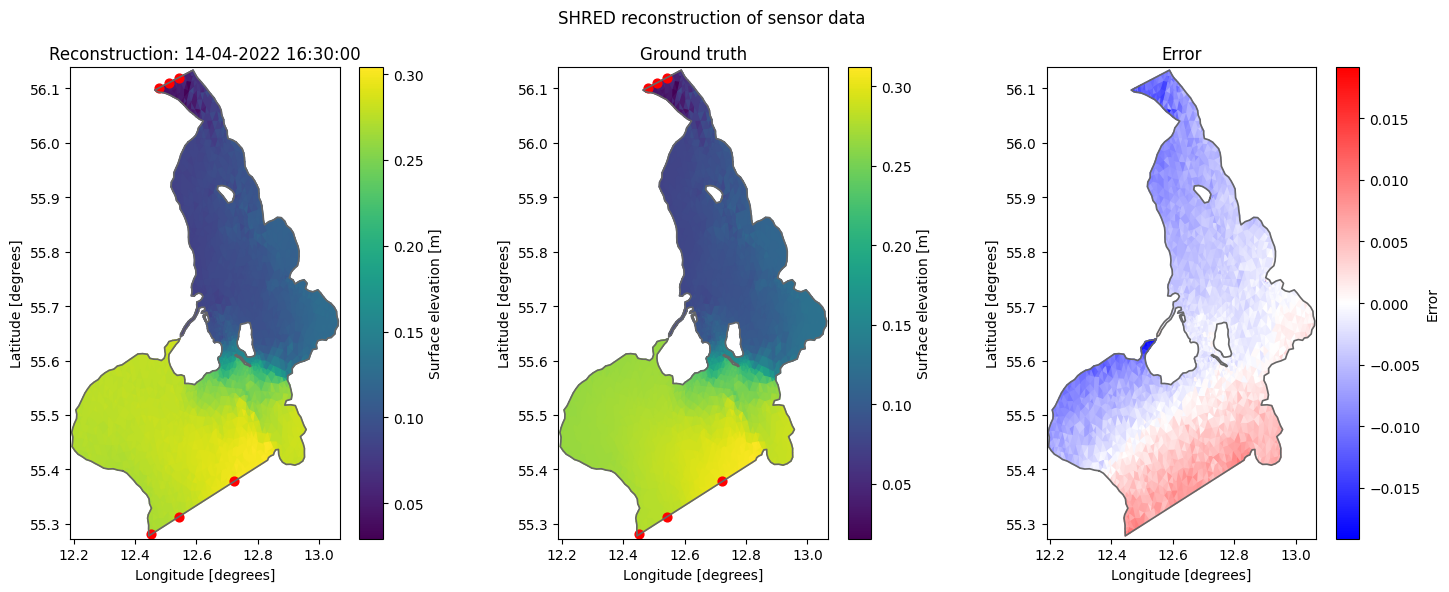

In [14]:
plot_index = 10
sensor_coord = np.concatenate((ds[0].geometry.node_coordinates[ds[0].geometry.codes==2,:],
                               ds[0].geometry.node_coordinates[(ds[0].geometry.codes==3)][1:-1]), axis=0)[sensor_locations]

rmspe, rmse = plot_reconstruction(reconstruction,truths,plot_index, sensor_coord, num_sensors=6)
compute_RMSES(reconstruction,truths)

# Run forecast with forcing SHRED model in 2023

In [15]:
import models
import torch
import pickle 

num_sensors = 6
val_length = 20
lags = 52
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize model with trained parameters
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.0)
# Load weights of trained model
shred.load_weights("models/oresund_forcing/shred_reconstruction_forcing_sensor6lag52.pt",device=device)

In [16]:
# Setup data
times = slice("2023-01-01", "2023-12-31")
ds = mikeio.read("Data/Area.dfsu",time=times, items=[0])
load_X = ds[0].to_numpy()
n = load_X.shape[0]
m = load_X.shape[1]
dsn = mikeio.read("Data/oresund/BC_SFC_North_2D_2014-2024.dfs1",time=times, items=[0])
dss = mikeio.read("Data/oresund/BC_SFC_South_2D_2014-2024.dfs1",time=times, items=[0])
load_y = np.concatenate((dsn.to_numpy().squeeze(), dss.to_numpy().squeeze()[:,1:-1]), axis=1)


sc = pickle.load(open("ReconstructingResults/oresund_forcing/scaler_forcing_sensor6lag52.sav",'rb'))

sc_y = pickle.load(open("ReconstructingResults/oresund_forcing/scaler_y_forcing_sensor6lag52.sav",'rb'))
sc_y = sc_y.fit(load_y)
transformed_y = sc_y.transform(load_y)


### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags+1, lags, num_sensors))
# Set up input data with lags
for i in range(len(all_data_in)):
# Use the forcing data as sensor input
    all_data_in[i] = transformed_y[i:i+lags, sensor_locations]


truths = load_X[lags - 1 :]

In [17]:
# Perform forecast with SHRED:
# Corresponds to a reconstruction from the forcing data to the full domain
reconstruction = sc.inverse_transform(shred(torch.tensor(all_data_in, dtype=torch.float32).to(device)).detach().numpy())

In [18]:
plt.rcParams['font.size'] = 10

RMSE:  0.06335456
RMSPE: 2130.2163


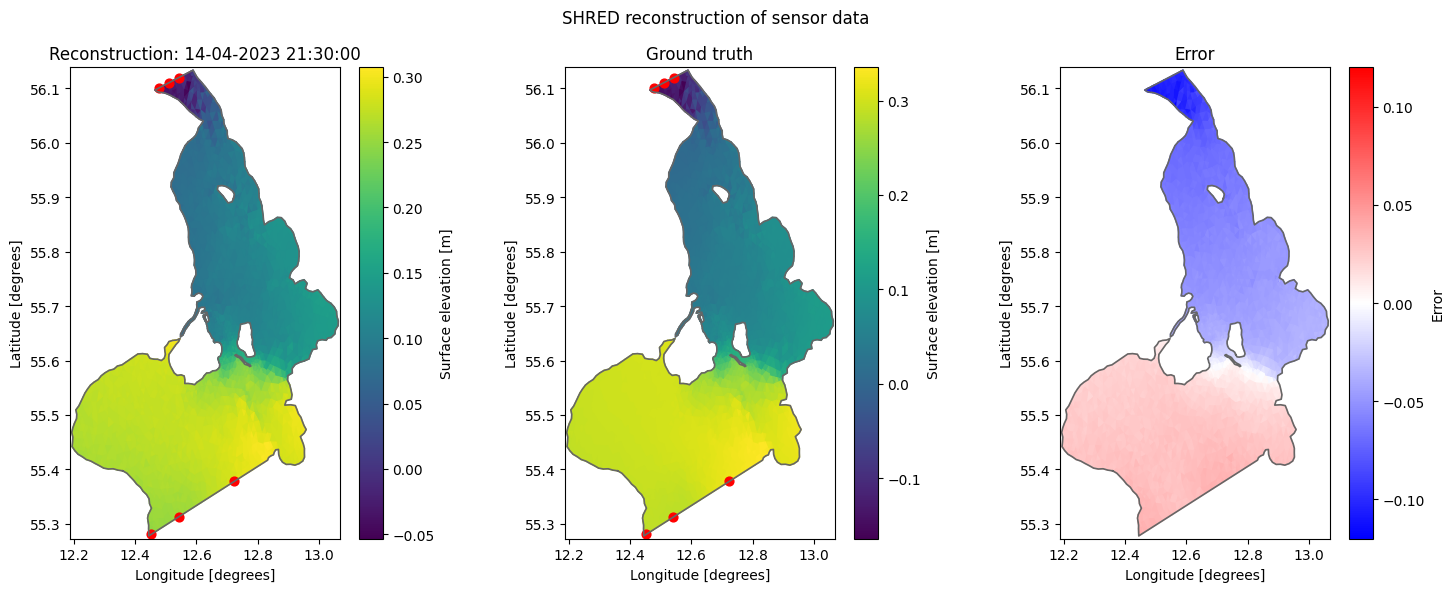

In [19]:
plot_index = 20
rmspe, rmse = plot_reconstruction(reconstruction,truths,plot_index, sensor_coord, num_sensors=6)
compute_RMSES(reconstruction,truths)

In [20]:
from plotting import plot_RMSE_spatial,plot_abs_err_quantiles,plot_scatter

ds_true = ds.sel(time=ds.time[np.arange(lags-1, n)])
ds_pred = ds_true.copy()
ds_pred[0].values = reconstruction


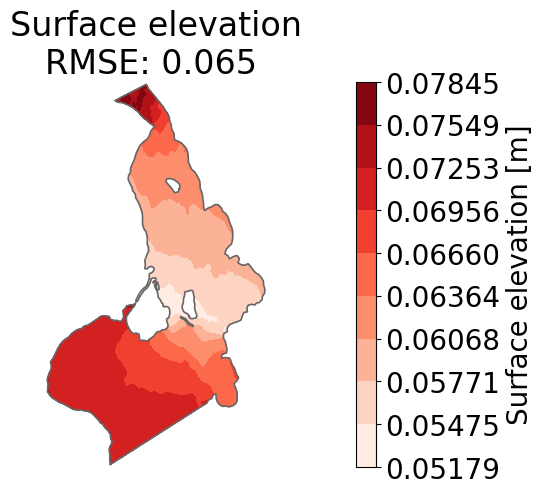

In [21]:
plot_RMSE_spatial(ds_pred,ds_true, None, config=None, fig_name_prefix="",cmap_err="Reds",save_fig = False, show_fig = True,var_names=None)

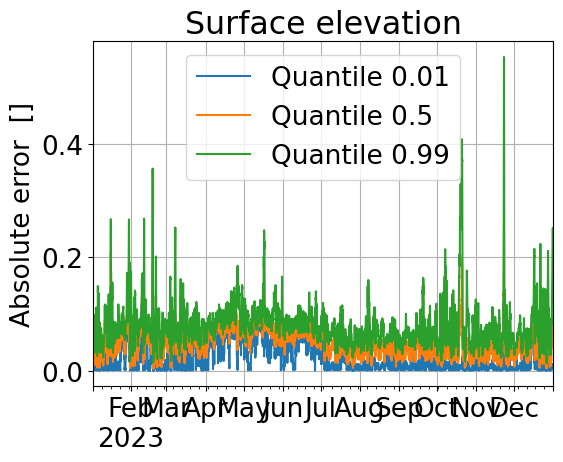

In [22]:
plot_abs_err_quantiles(ds_pred,ds_true,fig_path=None,fig_name_prefix="",config=None,save_fig = False, show_fig = True,var_names=None,q=[0.05,0.5,0.95])

<Figure size 640x480 with 0 Axes>

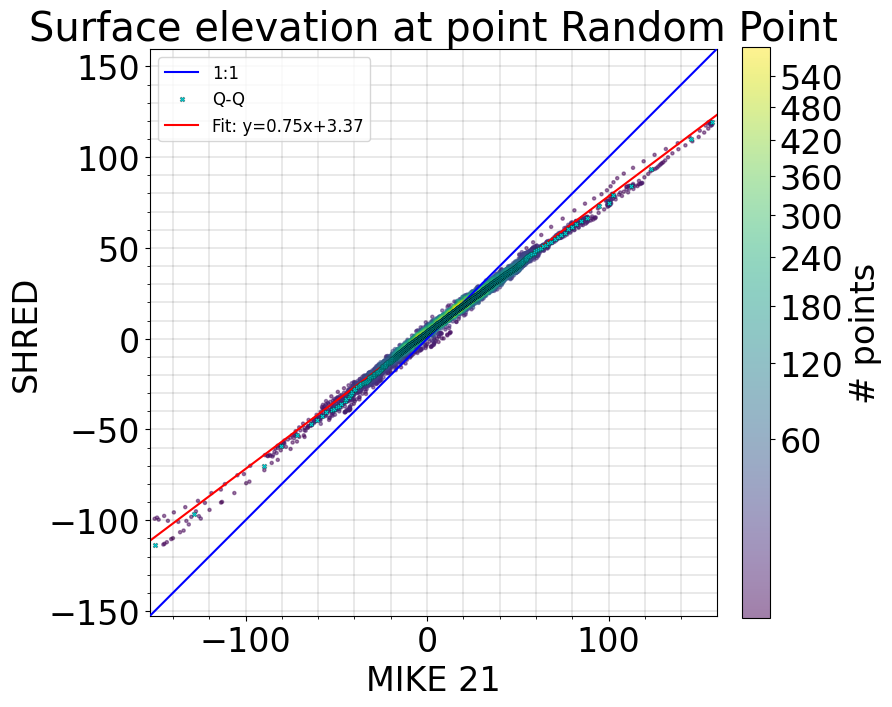

In [24]:
config = {'plot_point_position': [12.5,55.5],
          'plot_point_name': "Random Point",}
plot_scatter(ds_pred,ds_true,mod_name="SHRED",fig_path=None,fig_name_prefix="",config=config,save_fig=False, show_fig=True,var_names=None)

In [25]:
compute_RMSES(ds_pred[0].values,ds_true[0].values)

RMSE:  0.06335456
RMSPE: 2130.2163
